In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.errors import InvalidArgumentError
import tensorflow as tf


# Tensorflow GPU settings
# gpu_options = tf.GPUOptions(allow_growth=True)#per_process_gpu_memory_fraction=0.5)
# sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle

from scipy import interpolate

import keras_tuner as kt
import sys

2022-03-02 06:37:55.527962: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-02 06:37:56.383379: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-02 06:37:56.384180: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-02 06:37:56.390132: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-02 06:37:56.390153: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-02 06:37:56.391569: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-0

Define functions

In [2]:
def yield_and_error(df):
    '''
    input: 
    df  : dataframe
    
    output:
    yield (significance, error)
    '''
    Y  = -1
    dY = -1
    Y  = sum(df.wgt)
    dY = np.sqrt(sum(df.wgt**2))
    # return tuple
    return Y, dY


def significance_and_error(S, dS, B, dB):
    '''
    input: 
    S  : signal
    dS : signal error
    B  : background
    dB : background error
    
    output:
    tuple (significance, error)
    '''
    # FAKE SIGNIFICANCE
#     significance = S/np.sqrt(B)
#     error        = np.sqrt( 1/B*(dS**2) + (S**2)/(4*B**3)*(dB**2) )
#     return significance, error
    
    # REAL SIGNIFICANCE
    # if a quantity is negative, return 0
    if (S<=0 or B<=0):
        return 0, 0
#     S = np.abs(S)
#     B = np.abs(B)
    # calculate the significance and its error
    significance = np.sqrt( 2*((S + B)*np.log(1 + S/B) - S) )
    dSignifdS    = np.log(1 + S/B)/significance
    dSignifdB    = ( np.log(1 + S/B) - S/B )/significance
    error        = np.sqrt( (dSignifdS*dS)**2 + (dSignifdB*dB)**2 )
    # return tuple
    return significance, error


def add_in_quadrature_3( XdX, YdY, ZdZ ):
    '''
    input: 
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    x, dx = XdX
    y, dy = YdY
    z, dz = ZdZ
    # calculate the addition in quadrature and its error
    quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
    A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
    B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error


def add_in_quadrature_n( my_inputs ):
    '''
    input: 
    a list of the type [XdX, YdY, ZdZ, etc.]
    where
    XdX : tuple (significance, error)
    YdY : tuple (significance, error)
    ZdZ : tuple (significance, error)
    
    output:
    tuple (significance, error) added in quadrature
    '''
    # unpack the significances
    values = np.array([])
    errors = np.array([])
    for i in range(len(my_inputs)):
        x, dx = my_inputs[i]
        values = np.append(values, x)
        errors = np.append(errors, dx)
    # calculate the addition in quadrature and its error
    quadrature_sum = np.sqrt(sum(values**2))
    
    A = sum((values**2)*(errors**2))
    B = sum(values**2)
    
#     quadrature_sum   = np.sqrt(x**2 + y**2 + z**2)
#     A                = (x**2)*(dx**2) + (y**2)*(dy**2) + (z**2)*(dz**2)
#     B                = (x**2) + (y**2) + (z**2)
    if (quadrature_sum==0):
        return 0, 0
    quadrature_error = np.sqrt( A / B )
    # return tuple
    return quadrature_sum, quadrature_error


def total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    return significance, error

def print_total_significance_and_error( df_sig, df_bg ):
    
    m_list = []
    for sr in [0,1,2]:
        S, dS = yield_and_error(df_sig[df_sig.SR == sr])
        print("--- S = {:.2f} ± {:.2f} ".format(S, dS))
        B, dB = yield_and_error( df_bg[ df_bg.SR == sr])
        print("--- B = {:.2f} ± {:.2f} ".format(B, dB))
        m_list.append(significance_and_error(S, dS, B, dB))
    significance, error = add_in_quadrature_3(m_list[0], m_list[1], m_list[2])
    print("SF-inZ significance = {:.2f} ± {:.2f} ".format(m_list[0][0], m_list[0][1]))
    print("SF-noZ significance = {:.2f} ± {:.2f} ".format(m_list[1][0], m_list[1][1]))
    print("DF significance     = {:.2f} ± {:.2f} ".format(m_list[2][0], m_list[2][1]))
    print("Total significance  = {:.2f} ± {:.2f} ".format(significance, error))


test

In [3]:
add_in_quadrature_3((1.2,0.1),(1.6,0.2),(2.4,0.2))

(3.1240998703626617, 0.1886101017756029)

In [4]:
add_in_quadrature_n([(1.2,0.1),(1.6,0.2),(2.4,0.2),(3.4,0.1)])

(4.6173585522460785, 0.14733403229794106)

# Real ML starts here

In [7]:
this_channel = '20220301_ELReLMIs54_MUReLMIs31_btag77'

sig = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/' + this_channel + '_VVZ_RD.arrow')
sig = sig[sig.SR == 0]
sig['is_signal'] = True
sig = sig.reset_index(drop=True)

bg = pd.read_feather('/home/grabanal/WVZ/gabriel_ML_data/' + this_channel + '_FULLBG_RD.arrow')
bg = bg[bg.SR == 0]
bg['is_signal'] = False
bg = bg.reset_index(drop=True)

name = 'trained_in_SR0_btagCont'

In [8]:
print(len(sig), len(bg))
print(sum(sig.wgt), sum(bg.wgt))

39782 781892
5.2633852617844346 1069.8244928420672


In [9]:
print_total_significance_and_error(sig, bg)

--- S = 5.26 ± 0.05 
--- B = 1069.82 ± 3.53 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.16 ± 0.00 
SF-noZ significance = 0.00 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.16 ± 0.00 


In [10]:
sig.columns

Index(['index', 'Wlep1_phi', 'jet_eta_3', 'jet_btagCont_2', 'Zlep1_phi',
       'Wlep1_ambiguous', 'leptonic_HT', 'Zlep2_pt', 'jet_m_2', 'jet_pt_2',
       'lep4_ambiguous', 'METSig', 'jet_eta_4', 'jet_m_3', 'Zlep2_phi', 'MET',
       'other_mass', 'jet_m_4', 'Wlep2_pid', 'jet_eta_1', 'Wlep1_dphi',
       'Zlep1_pt', 'eta_3', 'eta_4', 'jet_pt_4', 'METPhi', 'wgt', 'jet_eta_2',
       'phi_4', 'v_j_btag70', 'phi_1', 'jet_btagCont_4', 'jet_phi_2',
       'jet_phi_3', 'Wlep2_ambiguous', 'Zlep1_dphi', 'Zlep1_pid', 'lep4_pid',
       'mass_4l', 'Zlep2_pid', 'pt_4l', 'lep1_ambiguous', 'SR', 'Wlep1_pt',
       'lep2_pid', 'Wlep1_pid', 'v_j_btag77', 'Wlep2_phi', 'chisq',
       'Zlep1_ambiguous', 'jet_pt_3', 'jet_m_1', 'eta_1', 'v_j_btag85',
       'jet_btagCont_3', 'total_HT', 'Zlep2_ambiguous', 'lep3_ambiguous',
       'Zlep1_eta', 'Zlep2_dphi', 'lep3_pid', 'jet_btagCont_1', 'HT', 'pt_2',
       'pt_4', 'pt_3', 'Wlep1_eta', 'Wlep2_dphi', 'phi_3', 'Zlep2_eta',
       'jet_pt_1', 'pt_1', 'jet_p

In [13]:

# lep_dphi_cols = ['Zlep1_pt', 'Zlep1_eta', 'Zlep1_dphi', 
#                  'Zlep2_pt', 'Zlep2_eta', 'Zlep2_dphi', 
#                  'Wlep1_pt', 'Wlep1_eta', 'Wlep1_dphi', 
#                  'Wlep2_pt', 'Wlep2_eta', 'Wlep2_dphi', 
#                  'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid','Wlep2_pid', 
#                  'pt_1', 'pt_2', 'pt_4', 'pt_3', 
#                  'Zcand_mass', 'other_mass', 'mass_4l', 'pt_4l',
#                  'leptonic_HT', 'HT',  'total_HT',   
#                  'MET', 'METSig', 
#                  'Njet',
#                  'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4',
#                  'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4',
#                  'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4',]

                 
lep_dphi_cols = ['Zlep1_pt', 'Zlep1_eta', 'Zlep1_dphi', 
                 'Zlep2_pt', 'Zlep2_eta', 'Zlep2_dphi', 
                 'Wlep1_pt', 'Wlep1_eta', 'Wlep1_dphi', 
                 'Wlep2_pt', 'Wlep2_eta', 'Wlep2_dphi', 
                 'Zlep1_pid', 'Zlep2_pid', 'Wlep1_pid','Wlep2_pid', 
                 'pt_1', 'pt_2', 'pt_4', 'pt_3', 
                 'Zcand_mass', 'other_mass', 'mass_4l', 'pt_4l',
                 'leptonic_HT', 'HT',  'total_HT',   
                 'MET', 'METSig', 
                 'Njet',
                 'jet_pt_1', 'jet_pt_2', 'jet_pt_3', 'jet_pt_4',
                 'jet_eta_1', 'jet_eta_2', 'jet_eta_3', 'jet_eta_4',
                 'jet_m_1', 'jet_m_2', 'jet_m_3', 'jet_m_4',
                 'jet_btagCont_1','jet_btagCont_2','jet_btagCont_3','jet_btagCont_4']

X = pd.concat([sig[lep_dphi_cols], bg[lep_dphi_cols]], ignore_index=True)

In [14]:
# Normalize inputs for NN training
min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler.fit(X)

for df in [sig, bg]:
    df[lep_dphi_cols] = min_max_scaler.transform(df[lep_dphi_cols])

In [15]:
sig['dummy_wgt'] = 1
bg['dummy_wgt']  = 1

In [16]:
# Split train and test data

# sig_train, sig_test = train_test_split(sig[lep_dphi_cols + ['wgt'] + ['SR']], train_size=0.5)
# bg_train, bg_test = train_test_split(bg[lep_dphi_cols + ['wgt'] + ['SR']], train_size=0.5)
sig_train, sig_test = train_test_split(sig[lep_dphi_cols + ['dummy_wgt'] + ['wgt'] + ['SR']], train_size=0.5)
bg_train,  bg_test  = train_test_split( bg[lep_dphi_cols + ['dummy_wgt'] + ['wgt'] + ['SR']], train_size=0.5)

n_sig = len(sig_train) # should be weighted?
n_bg = len(bg_train)

# weighted
n_sig = sum(sig_train['wgt']) 
n_bg = sum(bg_train['wgt'])

x_train = pd.concat([sig_train[lep_dphi_cols], bg_train[lep_dphi_cols]])
y_train = np.concatenate([np.ones(len(sig_train)), np.zeros(len(bg_train))]) # [1,1,...,0,0,...]
wgt_train = np.concatenate([sig_train['wgt'], bg_train['wgt']])
# Scaling the weight and dummy weights:
w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['wgt'], 
                                    (n_sig + n_bg) / n_bg  *  bg_train['wgt']]))
dummy_w_train = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_train['dummy_wgt'], 
                                          (n_sig + n_bg) / n_bg  *  bg_train['dummy_wgt']]))
SR_train = np.concatenate([sig_train['SR'], bg_train['SR']])
# sklearn.utils import shuffle
x_train, y_train, wgt_train, w_train, dummy_w_train, SR_train = shuffle(x_train, y_train, wgt_train, w_train, dummy_w_train, SR_train)


n_sig = len(sig_test) 
n_bg = len(bg_test)

# weighted
n_sig = sum(sig_test['wgt']) 
n_bg = sum(bg_test['wgt'])


x_test = pd.concat([sig_test[lep_dphi_cols], bg_test[lep_dphi_cols]])
y_test = np.concatenate([np.ones(len(sig_test)), np.zeros(len(bg_test))])  # [1,1,...,0,0,...]
wgt_test = np.concatenate([sig_test['wgt'], bg_test['wgt']])
# Scaling the weight and dummy weights:
w_test = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_test['wgt'], 
                                   (n_sig + n_bg) / n_bg  * bg_test['wgt']]))
dummy_w_test = pd.Series(np.concatenate([(n_sig + n_bg) / n_sig * sig_test['dummy_wgt'], 
                                         (n_sig + n_bg) / n_bg  *  bg_test['dummy_wgt']]))
SR_test = np.concatenate([sig_test['SR'], bg_test['SR']])


In [17]:
print(len(sig_train), len(bg_train), len(y_train), len(w_train))
print("Training sample")
print_total_significance_and_error(sig_train, bg_train)

19891 390946 410837 410837
Training sample
--- S = 2.63 ± 0.03 
--- B = 534.70 ± 2.57 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.11 ± 0.00 
SF-noZ significance = 0.00 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.11 ± 0.00 


In [18]:
print(len(sig_test), len(bg_test), len(y_test), len(w_test))
print("Eval sample")
print_total_significance_and_error(sig_test, bg_test)

19891 390946 410837 410837
Eval sample
--- S = 2.63 ± 0.03 
--- B = 535.12 ± 2.42 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
--- S = 0.00 ± 0.00 
--- B = 0.00 ± 0.00 
SF-inZ significance = 0.11 ± 0.00 
SF-noZ significance = 0.00 ± 0.00 
DF significance     = 0.00 ± 0.00 
Total significance  = 0.11 ± 0.00 


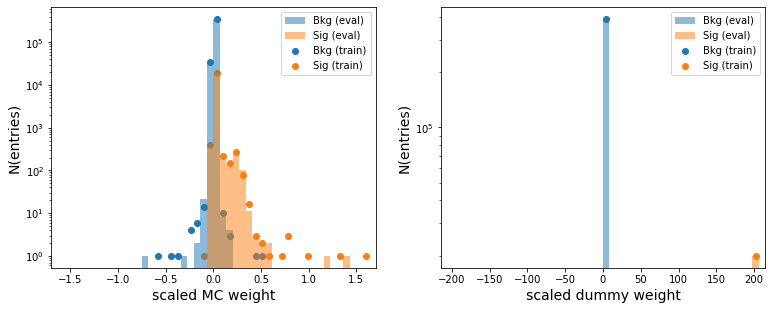

In [19]:
plt.figure(figsize=[2*6.4,1*4.8])

b = 50
ax = plt.subplot(1, 2, 1)
m = 1.05*np.max([np.max(abs(w_train)), np.max(abs(w_test))])
# plot test
_, b, _ = plt.hist(w_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')
_, b, _ = plt.hist(w_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)')
# plot train
bin_centers = (b[:-1]+b[1:])/2
w_train_bg  = np.histogram(w_train[y_train == 0], bins=b)[0]
w_train_sig = np.histogram(w_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, w_train_bg,  label='Bkg (train)')
plt.scatter(bin_centers, w_train_sig, label='Sig (train)')
plt.xlim([-m,m])
plt.yscale('log')
plt.legend()
plt.xlabel('scaled MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(1, 2, 2)
m = 1.05*np.max([np.max(abs(dummy_w_train)), np.max(abs(dummy_w_test))])
# plot test
_, b, _ = plt.hist(dummy_w_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')
_, b, _ = plt.hist(dummy_w_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)')
bin_centers = (b[:-1]+b[1:])/2
# plot train
dummy_w_train_bg  = np.histogram(dummy_w_train[y_train == 0], bins=b)[0]
dummy_w_train_sig = np.histogram(dummy_w_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, dummy_w_train_bg,  label='Bkg (train)')
plt.scatter(bin_centers, dummy_w_train_sig, label='Sig (train)')
plt.xlim([-m,m])
plt.yscale('log')
plt.legend()
plt.xlabel('scaled dummy weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

plt.savefig('plots/scaled_weights_{}.pdf'.format(name))

plt.show()

Zoomed-in version of the normal MC weight, to see the substructure:

0.008348174604428743
0.00016696349208857487


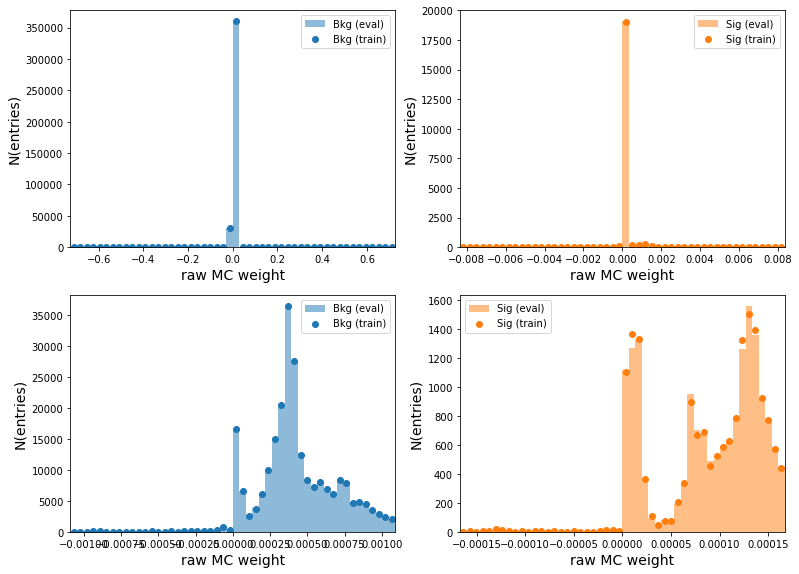

In [20]:
fig = plt.figure(figsize=[2*6.4,2*4.8])

b = 50
ax = plt.subplot(2, 2, 1)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==0])), np.max(abs(wgt_test[y_test==0]))])
# plot test
_, b, _ = plt.hist(wgt_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_bg  = np.histogram(wgt_train[y_train == 0], bins=b)[0]
plt.scatter(bin_centers, wgt_train_bg,  label='Bkg (train)')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(2, 2, 2)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==1])), np.max(abs(wgt_test[y_test==1]))])
print(m)
# plot test
_, b, _ = plt.hist(wgt_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)', color='C1')
# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_sig = np.histogram(wgt_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, wgt_train_sig, label='Sig (train)', color='C1')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)


b = 50
ax = plt.subplot(2, 2, 3)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==0])), np.max(abs(wgt_test[y_test==0]))])*0.0015
# plot test
_, b, _ = plt.hist(wgt_test[y_test==0], bins=b, alpha=0.5, range=(-m,m), label='Bkg (eval)')# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_bg  = np.histogram(wgt_train[y_train == 0], bins=b)[0]
plt.scatter(bin_centers, wgt_train_bg,  label='Bkg (train)')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

b = 50
ax = plt.subplot(2, 2, 4)
m = 1.05*np.max([np.max(abs(wgt_train[y_train==1])), np.max(abs(wgt_test[y_test==1]))])*0.02
print(m)
# plot test
_, b, _ = plt.hist(wgt_test[y_test==1], bins=b, alpha=0.5, range=(-m,m), label='Sig (eval)', color='C1')
# plot train
bin_centers = (b[:-1]+b[1:])/2
wgt_train_sig = np.histogram(wgt_train[y_train == 1], bins=b)[0]
plt.scatter(bin_centers, wgt_train_sig, label='Sig (train)', color='C1')
plt.xlim([-m,m])
# plt.yscale('log')
plt.legend()
plt.xlabel('raw MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)

plt.savefig('plots/raw_weights_{}.pdf'.format(name))
plt.show()

# Fit ML classifier

In [21]:
use_mc_weights = True
# use_mc_weights = False

# Chop off the negative weights?

Train and evaluate!

In [22]:
# Fit ML classifier
EPOCHS = 10000
patience = 20
batch_size = 256
num_nodes = 64
dropout = 0.1
learn_rate = 1e-3

v_classifier = []
v_history = []

n_models = 10

x_test_results = x_test.copy()

for i in range(n_models):
    print("Running model", i)
    
    # Generate and fit model
    K.clear_session()

# Generate and fit model
    K.clear_session()
    classifier = Sequential()
    classifier.add(Dense(num_nodes, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(num_nodes, activation='relu'))
    classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    if (use_mc_weights):
        history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
                                verbose=1, callbacks=[callback])
    else:
        history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
                                validation_data=(x_test, y_test, dummy_w_test), sample_weight=dummy_w_train, 
                                verbose=1, callbacks=[callback])
    
    v_classifier.append(classifier)
    v_history.append(history)
    
    x_test_results['pred_' + str(i)] = classifier.predict(x_test, batch_size=batch_size)

Running model 0


2022-03-02 06:38:33.877004: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 06:38:33.879057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 4000 computeCapability: 7.5
coreClock: 1.545GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 387.49GiB/s
2022-03-02 06:38:33.879103: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-02 06:38:33.879120: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-03-02 06:38:33.879129: I tensorflow/stream_executor/plat

Epoch 1/10000


2022-03-02 06:38:35.166872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


1605/1605 [==============================] - 12s 7ms/step - loss: 0.0015 - accuracy: 0.5862 - val_loss: 0.0012 - val_accuracy: 0.6218
Epoch 2/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0012 - accuracy: 0.6112 - val_loss: 0.0011 - val_accuracy: 0.6176
Epoch 3/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0012 - accuracy: 0.6176 - val_loss: 0.0011 - val_accuracy: 0.6623
Epoch 4/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0012 - accuracy: 0.6361 - val_loss: 0.0011 - val_accuracy: 0.6644
Epoch 5/10000
1605/1605 [==============================] - 10s 7ms/step - loss: 0.0011 - accuracy: 0.6363 - val_loss: 0.0011 - val_accuracy: 0.6791
Epoch 6/10000
1605/1605 [==============================] - 10s 6ms/step - loss: 0.0011 - accuracy: 0.6357 - val_loss: 0.0011 - val_accuracy: 0.5903
Epoch 7/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6307 - val_loss: 0.0011 -

1605/1605 [==============================] - 12s 7ms/step - loss: 9.9546e-04 - accuracy: 0.6482 - val_loss: 0.0011 - val_accuracy: 0.7211
Epoch 57/10000
1605/1605 [==============================] - 12s 7ms/step - loss: 9.9821e-04 - accuracy: 0.6444 - val_loss: 0.0010 - val_accuracy: 0.6437
Epoch 58/10000
1605/1605 [==============================] - 12s 7ms/step - loss: 9.9439e-04 - accuracy: 0.6535 - val_loss: 0.0011 - val_accuracy: 0.6735
Epoch 59/10000
1605/1605 [==============================] - 12s 7ms/step - loss: 9.7455e-04 - accuracy: 0.6526 - val_loss: 0.0011 - val_accuracy: 0.6862
Epoch 60/10000
1605/1605 [==============================] - 12s 7ms/step - loss: 9.9149e-04 - accuracy: 0.6570 - val_loss: 0.0010 - val_accuracy: 0.6795
Epoch 61/10000
1605/1605 [==============================] - 12s 7ms/step - loss: 9.8464e-04 - accuracy: 0.6510 - val_loss: 0.0010 - val_accuracy: 0.6597
Epoch 62/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 9.8467e-04 - acc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1605/1605 [==============================] - 10s 6ms/step - loss: 0.0010 - accuracy: 0.6393 - val_loss: 0.0011 - val_accuracy: 0.6535
Running model 2
Epoch 1/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0016 - accuracy: 0.5829 - val_loss: 0.0012 - val_accuracy: 0.5992
Epoch 2/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6368 - val_loss: 0.0011 - val_accuracy: 0.7038
Epoch 15/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6415 - val_loss: 0.0011 - val_accuracy: 0.6431
Epoch 16/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6349 - val_loss: 0.0011 - val_accuracy: 0.6463
Epoch 17/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6435 - val_loss: 0.0011 - val_accuracy: 0.5452
Epoch 18/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6387 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1605/1605 [==============================] - 11s 7ms/step - loss: 0.0010 - accuracy: 0.6419 - val_loss: 0.0010 - val_accuracy: 0.5973
Epoch 40/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0010 - accuracy: 0.6381 - val_loss: 0.0011 - val_accuracy: 0.6103
Epoch 41/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0010 - accuracy: 0.6284 - val_loss: 0.0011 - val_accuracy: 0.6925
Epoch 42/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0010 - accuracy: 0.6503 - val_loss: 0.0011 - val_accuracy: 0.6438
Epoch 43/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0010 - accuracy: 0.6459 - val_loss: 0.0011 - val_accuracy: 0.6803
Epoch 44/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0010 - accuracy: 0.6501 - val_loss: 0.0011 - val_accuracy: 0.6414
Epoch 45/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0010 - accuracy: 0.6437 - val_loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6348 - val_loss: 0.0011 - val_accuracy: 0.6633
Epoch 12/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6380 - val_loss: 0.0011 - val_accuracy: 0.7411
Epoch 13/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6390 - val_loss: 0.0011 - val_accuracy: 0.6840
Epoch 14/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6385 - val_loss: 0.0011 - val_accuracy: 0.6642
Epoch 15/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6351 - val_loss: 0.0011 - val_accuracy: 0.6084
Epoch 16/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6326 - val_loss: 0.0011 - val_accuracy: 0.5647
Epoch 17/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6345 - val_loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6343 - val_loss: 0.0011 - val_accuracy: 0.6208
Epoch 13/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6269 - val_loss: 0.0011 - val_accuracy: 0.6688
Epoch 14/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6307 - val_loss: 0.0011 - val_accuracy: 0.6834
Epoch 15/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6343 - val_loss: 0.0011 - val_accuracy: 0.6741
Epoch 16/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6367 - val_loss: 0.0011 - val_accuracy: 0.6620
Epoch 17/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6313 - val_loss: 0.0011 - val_accuracy: 0.5748
Epoch 18/10000
1605/1605 [==============================] - 11s 7ms/step - loss: 0.0011 - accuracy: 0.6377 - val_loss: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Plot loss and accuracy vs. epoch

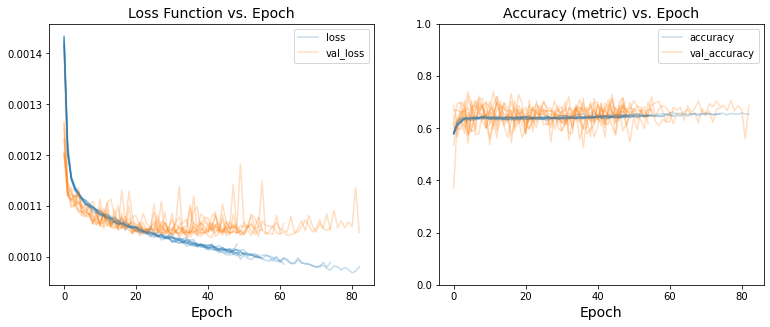

In [23]:
plt.figure(figsize=[2*6.4,1*4.8])

for i in range(n_models):
    
    this_NN = v_classifier[i]
    this_history = v_history[i]

    # Plot the significances with their error bars:
    ax = plt.subplot(1, 2, 1)
    # plt.figure()
    plt.title("Loss Function vs. Epoch", fontsize=14)
    plt.plot(this_history.history['loss'], alpha=0.25, color='C0')
    plt.plot(this_history.history['val_loss'], alpha=0.25, color='C1')
    plt.legend(['loss','val_loss'])
    plt.xlabel('Epoch', fontsize=14)
    # plt.ylabel('Loss', fontsize=14)
    
    # plt.yscale('log')

    ax = plt.subplot(1, 2, 2)
    # plt.figure()
    plt.title("Accuracy (metric) vs. Epoch", fontsize=14)
    plt.plot(this_history.history['accuracy'], alpha=0.25, color='C0')
    plt.plot(this_history.history['val_accuracy'], alpha=0.25, color='C1')
    plt.legend(['accuracy','val_accuracy'])
    plt.xlabel('Epoch', fontsize=14)
    plt.ylim([0,1])
    # plt.ylabel('Accuracy', fontsize=14)

plt.savefig('plots/loss_accuracy_{}.pdf'.format(name))
plt.show()

Add some variables

In [24]:
pred_columns = [c for c in x_test_results if c.startswith('pred')]
x_test_results['mean_pred'] = np.mean(x_test_results[pred_columns], axis=1)
x_test_results['is_signal'] = y_test
# Add the real weights back:
x_test_results['wgt'] = np.array(wgt_test)
x_test_results['SR'] = np.array(SR_test)
x_test_results['y'] = np.array(y_test)

x_train_results = x_train.copy()
x_train_results['pred'] = classifier.predict(x_train, batch_size=10000)
x_train_results['wgt'] = np.array(wgt_train) # wgt_train preserves the original weights, and shuffled
x_train_results['SR'] = np.array(SR_train)
x_train_results['y'] = np.array(y_train)

Plot yield vs NN output

# Normalized signal / background plot

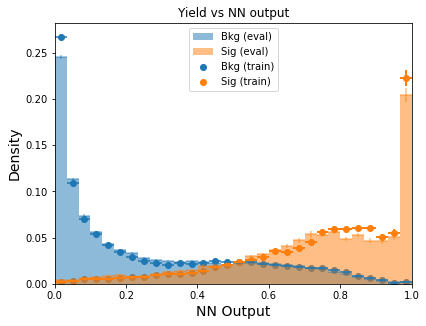

In [25]:
plt.figure(figsize=[1*6.4,1*4.8])

# BACKGROUND
# plt.subplot(1,2,1)
plt.title("Yield vs NN output")

n_bg_test = sum(wgt_test[y_test == 0])
n_bg_train = sum(wgt_train[y_train == 0])

n, b, _ = plt.hist(x_test_results[y_test == 0].mean_pred, bins=30, alpha=0.5, label='Bkg (eval)', 
                   weights = wgt_test[y_test == 0]/n_bg_test)
bin_centers = (b[:-1]+b[1:])/2
train_bg_bin_y = np.histogram(x_train_results[y_train == 0].pred, bins=b, 
                              weights = wgt_train[y_train == 0]/n_bg_train)[0]
scatter = plt.scatter(bin_centers, train_bg_bin_y, label='Bkg (train)')
# to plot error bars:
sumw2 = np.histogram(x_test_results[y_test == 0].mean_pred, bins=b, 
                              weights = (wgt_test[y_test == 0]/n_bg_test)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=n, xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C0', alpha=0.5)
# to plot error bars:
sumw2 = np.histogram(x_train_results[y_train == 0].pred, bins=b, 
                              weights = (wgt_train[y_train == 0]/n_bg_train)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=scatter.get_offsets().data[:,1], xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C0')


plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Yield', fontsize=14)
plt.xlim([0,1])
plt.legend()

# USING N(ENTRIES):
# ax = plt.subplot(1,2,2)
# plt.title("Signal Yield vs NN output")

n_sig_test = sum(wgt_test[y_test == 1])
n_sig_train = sum(wgt_train[y_train == 1])

n, b, _ = plt.hist(x_test_results[y_test == 1].mean_pred, bins=b, alpha=0.5, label='Sig (eval)', 
                   weights = wgt_test[y_test == 1]/n_sig_test, color='C1', linewidth=0)
bin_centers = (b[:-1]+b[1:])/2
train_sig_bin_y = np.histogram(x_train_results[y_train == 1].pred, bins=b, 
                              weights = wgt_train[y_train == 1]/n_sig_train)[0]
scatter = plt.scatter(bin_centers, train_sig_bin_y, label='Sig (train)', color='C1')
# to plot error bars:
sumw2 = np.histogram(x_test_results[y_test == 1].mean_pred, bins=b, 
                              weights = (wgt_test[y_test == 1]/n_sig_test)**2)[0]
bin_widths  = (b[1:]-b[:-1])/2
plt.errorbar(x=bin_centers, y=n, xerr=bin_widths, yerr=np.sqrt(sumw2), fmt=' ', color='C1', alpha=0.5)
# to plot error bars:
sumw2 = np.histogram(x_train_results[y_train == 1].pred, bins=b, 
                              weights = (wgt_train[y_train == 1]/n_sig_train)**2)[0]
plt.errorbar(x=bin_centers, y=scatter.get_offsets().data[:,1], xerr=bin_widths, yerr=np.sqrt(sumw2), 
             fmt=' ', color='C1', linewidth=2)

plt.xlabel('NN Output', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xlim([0,1])
plt.legend()

# plt.yscale('log')

# plt.savefig('plots/plot1_together_{}.pdf'.format(name))
plt.savefig('plots/plot1_together_normalized_{}.pdf'.format(name))
# plt.savefig('plots/plot1_together_normalized_log_{}.pdf'.format(name))

# plt.savefig('plots/2021-12-11_batch_' + str(batch_size) + '.pdf')
plt.show()

In [26]:
print(sum(wgt_test[y_test == 0]))
print(sum(wgt_train[y_train == 0]))

print(sum(wgt_test[y_test == 1]))
print(sum(wgt_train[y_train == 1]))

535.1208469982864
534.7036458437561
2.6301990940483226
2.6331861677360457


0.8281945656831466


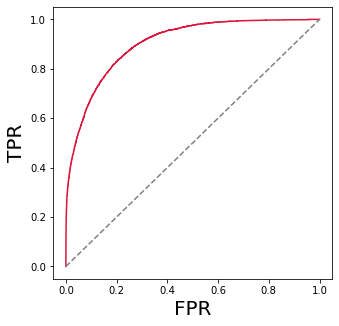

In [27]:
plt.figure(figsize=(5, 5))

# for c in ['pred_0', 'mean_pred']:
#     fpr, tpr, _ = roc_curve(y_test, x_test_results[c], sample_weight=w_test)

#     plt.plot(fpr, tpr)
    
for c in ['mean_pred']:
    fpr, tpr, _ = roc_curve(y_test, x_test_results[c], sample_weight=w_test)

    plt.plot(fpr, tpr, ls='-', color='crimson')
        
plt.plot([0, 1], [0, 1], ls='--', color='grey')
plt.xlabel('FPR', fontsize=20)
plt.ylabel('TPR', fontsize=20)
plt.savefig('plots/ROC_{}.pdf'.format(name))

print(sum(tpr)/len(fpr))

plt.show()

# Finder of best cut in each signal region

In [28]:
print('Finding the best NN cut in each separate signal region:')
print()


best_significances = []
best_cuts = []

# for plotting:
list_cuts = [[],[],[]]
list_significances = [[],[],[]]
list_significance_errors = [[],[],[]]
list_signal_yields = [[],[],[]]
list_signal_yield_errors = [[],[],[]]
list_background_yields = [[],[],[]]
list_background_yield_errors = [[],[],[]]

for i in [0,1,2]:
    
    if (i==0): 
        print("---- In the region SF-inZ ----")
    if (i==1): 
        print("---- In the region SF-noZ ----")
    if (i==2): 
        print("---- In the region DF ----")
        
    best_cut = 0
    maximum_significance = 0
    maximum_significance_error = 0
    best_S = 0
    best_dS = 0
    best_B = 0
    best_dB = 0

    data_passed_cut = x_test_results[x_test_results.SR==i]

    for x in np.linspace(0,0.99,200):
        cut = x
        data_passed_cut = data_passed_cut[data_passed_cut.mean_pred >= cut]
        sig_passed_cut = data_passed_cut[data_passed_cut.is_signal == 1]
        bg_passed_cut = data_passed_cut[data_passed_cut.is_signal == 0]

        n_sig_passed_cut = sum(sig_passed_cut.wgt)
        n_bg_passed_cut = sum(bg_passed_cut.wgt)

        S, dS  = yield_and_error(sig_passed_cut)
        B, dB  = yield_and_error(bg_passed_cut)
            
        if (S<0.25):
            continue
        if (B<0):
            print(B)
            continue
        if (S+B<10/4):
            continue
        significance, error = significance_and_error(S, dS, B, dB)
        
        list_cuts[i].append(cut)
        list_significances[i].append(significance)
        list_significance_errors[i].append(error)
        list_signal_yields[i].append(S)
        list_signal_yield_errors[i].append(dS)
        list_background_yields[i].append(B)
        list_background_yield_errors[i].append(dB)
        
        if (cut == 0):
            print('Original yields:')
            print(' S: %.2f ± %.2f events'%(S,dS))
            print(' B: %.2f ± %.2f events'%(B,dB))
            print(' Significance = %.2f ± %.2f'%(significance, error))
            print()

        if (significance > maximum_significance):
            best_cut = cut
            maximum_significance = significance
            maximum_significance_error = error
            best_S = S
            best_dS = dS
            best_B = B
            best_dB = dB
            
    best_significances.append((maximum_significance, maximum_significance_error))
    best_cuts.append(best_cut)

    print('Best NN cut: %.3f'%(best_cut))
    print('New yields:')
    print(' S: %.2f ± %.2f events'%(best_S,best_dS))
    print(' B: %.2f ± %.2f events'%(best_B,best_dB))
    print(' Significance = %.2f ± %.2f'%(maximum_significance, maximum_significance_error))
    print("------------------------------")
    print()
    
    
print("---- In quadrature ----")


temporal = []

for i in [0,1,2]:
    maximum_significance = 0
    maximum_significance_error = 0
    best_S = 0
    best_dS = 0
    best_B = 0
    best_dB = 0

    data_passed_cut = x_test_results[x_test_results.SR==i]
    sig_passed_cut = data_passed_cut[data_passed_cut.is_signal == 1]
    bg_passed_cut = data_passed_cut[data_passed_cut.is_signal == 0]

    S, dS  = yield_and_error(sig_passed_cut)
    B, dB  = yield_and_error(bg_passed_cut)
    
    temporal.append((significance_and_error(S, dS, B, dB)))

old_quad, old_quad_error = add_in_quadrature_3(temporal[0], temporal[1], temporal[2]) 
print("Old significance = {:.2f} ± {:.2f} ".format(old_quad, old_quad_error))

best_quad, best_quad_error = add_in_quadrature_3(best_significances[0], best_significances[1], best_significances[2]) 
print("Best significance = {:.2f} ± {:.2f} ".format(best_quad, best_quad_error))

Finding the best NN cut in each separate signal region:

---- In the region SF-inZ ----
Original yields:
 S: 2.63 ± 0.03 events
 B: 535.12 ± 2.42 events
 Significance = 0.11 ± 0.00

Best NN cut: 0.935
New yields:
 S: 0.70 ± 0.02 events
 B: 1.86 ± 0.17 events
 Significance = 0.48 ± 0.02
------------------------------

---- In the region SF-noZ ----
Best NN cut: 0.000
New yields:
 S: 0.00 ± 0.00 events
 B: 0.00 ± 0.00 events
 Significance = 0.00 ± 0.00
------------------------------

---- In the region DF ----
Best NN cut: 0.000
New yields:
 S: 0.00 ± 0.00 events
 B: 0.00 ± 0.00 events
 Significance = 0.00 ± 0.00
------------------------------

---- In quadrature ----
Old significance = 0.11 ± 0.00 
Best significance = 0.48 ± 0.02 


# END

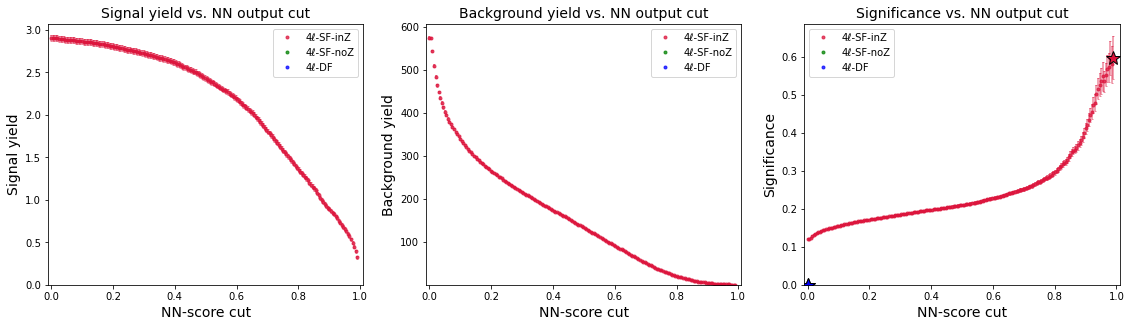

In [27]:
plt.figure(figsize=[3*6.4,1*4.8])

# Plot the significances with their error bars:
ax = plt.subplot(1, 3, 3)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Significance vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Significance', fontsize=14)
plt.errorbar(list_cuts[0], list_significances[0], yerr=list_significance_errors[0], 
             fmt=' ', capsize=1, color='crimson', alpha=0.5)
plt.plot(list_cuts[0],list_significances[0], 'o', markersize = 3, color='crimson', alpha=0.75)

plt.errorbar(list_cuts[1], list_significances[1], yerr=list_significance_errors[1], 
             fmt=' ', capsize=1, color='green', alpha=0.5)
plt.plot(list_cuts[1],list_significances[1], 'o', markersize = 3, color='green', alpha=0.75)

plt.errorbar(list_cuts[2],list_significances[2], yerr=list_significance_errors[2],
             fmt=' ', capsize=1, color='blue', alpha=0.5)
plt.plot(list_cuts[2],list_significances[2], 'o', markersize = 3, color='blue', alpha=0.75)
plt.legend(['4ℓ-SF-inZ','4ℓ-SF-noZ','4ℓ-DF'])
# Plot the maximums:
plt.plot(best_cuts[0], best_significances[0][0],'*', color='crimson', fillstyle='full', 
         markeredgecolor='black', markersize=15)
plt.plot(best_cuts[1], best_significances[1][0],'*', color='green', fillstyle='full', 
         markeredgecolor='black', markersize=15)
plt.plot(best_cuts[2], best_significances[2][0],'*', color='blue', fillstyle='full', 
         markeredgecolor='black', markersize=15)
plt.ylim(0)
plt.xlim([-0.01,1.01])
# plt.savefig('20211201.pdf')
# plt.show()

# Plot the signal yields with their error bars:
ax = plt.subplot(1, 3, 1)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Signal yield vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Signal yield', fontsize=14)
plt.errorbar(list_cuts[0], list_signal_yields[0], yerr=list_signal_yield_errors[0], 
             fmt=' ', capsize=1, color='crimson', alpha=0.5)
plt.plot(list_cuts[0],list_signal_yields[0], 'o', markersize = 3, color='crimson', alpha=0.75)

plt.errorbar(list_cuts[1], list_signal_yields[1], yerr=list_signal_yield_errors[1], 
             fmt=' ', capsize=1, color='green', alpha=0.5)
plt.plot(list_cuts[1],list_signal_yields[1], 'o', markersize = 3, color='green', alpha=0.75)

plt.errorbar(list_cuts[2],list_signal_yields[2], yerr=list_signal_yield_errors[2], 
             fmt=' ', capsize=1, color='blue', alpha=0.5)
plt.plot(list_cuts[2],list_signal_yields[2], 'o', markersize = 3, color='blue', alpha=0.75)
plt.ylim(0)
plt.xlim([-0.01,1.01])
plt.legend(['4ℓ-SF-inZ','4ℓ-SF-noZ','4ℓ-DF'])

# Plot the background yields with their error bars:
ax = plt.subplot(1, 3, 2)
# plt.figure(figsize=[1.5*6.4,1.5*4.8])
plt.title('Background yield vs. NN output cut', fontsize=14)
plt.xlabel('NN-score cut', fontsize=14)
plt.ylabel('Background yield', fontsize=14)
plt.errorbar(list_cuts[0], list_background_yields[0], yerr=list_background_yield_errors[0], 
             fmt=' ', capsize=1, color='crimson', alpha=0.5)
plt.plot(list_cuts[0],list_background_yields[0], 'o', markersize = 3, color='crimson', alpha=0.75)

plt.errorbar(list_cuts[1], list_background_yields[1], yerr=list_background_yield_errors[1], 
             fmt=' ', capsize=1, color='green', alpha=0.5)
plt.plot(list_cuts[1],list_background_yields[1], 'o', markersize = 3, color='green', alpha=0.75)

plt.errorbar(list_cuts[2],list_background_yields[2], yerr=list_background_yield_errors[2], 
             fmt=' ', capsize=1, color='blue', alpha=0.5)
plt.plot(list_cuts[2],list_background_yields[2], 'o', markersize = 3, color='blue', alpha=0.75)
plt.ylim(0.0001)
plt.xlim([-0.01,1.01])
# plt.yscale('log')
plt.legend(['4ℓ-SF-inZ','4ℓ-SF-noZ','4ℓ-DF'])

plt.savefig('plots/plot2_{}.pdf'.format(name))
plt.show()

## Plot weight distribution in some samples separated by physics process

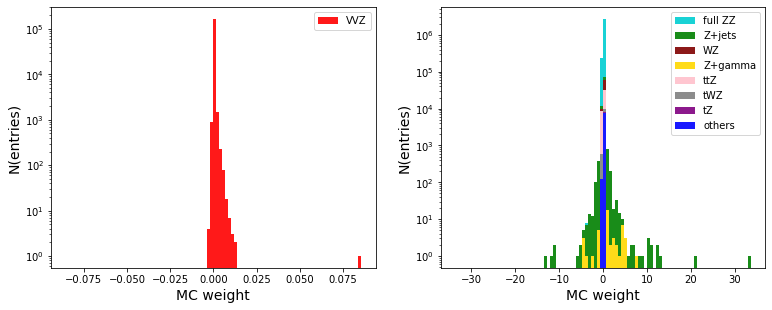

In [67]:
VVZ     = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_VVZ.arrow')
ZZ       = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_ZZ.arrow')
WZ       = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_WZ.arrow')
Zjets_new  = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_Zjets.arrow')
Zgamma = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_Zgamma.arrow')
ttZ    = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_ttZ.arrow')
tZ     = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_tZ.arrow')
tWZ    = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_tWZ.arrow')
others = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_others.arrow')
FULLBG = pd.read_feather('/home/grabanal/minitree/20211129_no_iso_FULLBG.arrow')

# VVZ     = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_VVZ.arrow')
# ZZ       = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_ZZ.arrow')
# WZ       = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_WZ.arrow')
# Zjets_new  = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_Zjets.arrow')
# Zgamma = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_Zgamma.arrow')
# ttZ    = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_ttZ.arrow')
# tZ     = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_tZ.arrow')
# tWZ    = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_tWZ.arrow')
# others = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_others.arrow')
# FULLBG = pd.read_feather('/home/grabanal/minitree/20211129_iso_e4m1_FULLBG.arrow')


individual_backgrounds = [ZZ, WZ, Zjets_new, Zgamma, ttZ, tZ, tWZ, others]

order = [others, tZ, tWZ, ttZ, Zgamma, WZ, Zjets_new, ZZ]


plt.figure(figsize=[2*6.4,1*4.8])
variable, denom, my_range, my_bins = 'wgt', 1, (-30,30), 100
my_alpha = 0.9



ax = plt.subplot(1, 2, 1)
plt.xlabel('MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)
max_wgt = np.maximum( abs(np.min(VVZ['wgt'])), np.max(VVZ['wgt']) ) 
my_range = (-max_wgt,max_wgt)
n, bins, patches = plt.hist(VVZ[variable]/denom, range=my_range,
                            bins=my_bins, alpha=my_alpha, color='red', label='VVZ')
ax.legend(['VVZ'])
plt.yscale('log')
    

    
ax = plt.subplot(1, 2, 2)
plt.xlabel('MC weight', fontsize=14)
plt.ylabel('N(entries)', fontsize=14)
colors = ('blue','purple','grey','pink', 'gold', 'maroon','green','darkturquoise')
labels = ('others', 'tZ', 'tWZ', 'ttZ', 'Z+gamma', 'WZ', 'Z+jets', 'full ZZ')
max_wgt = np.maximum( abs(np.min(FULLBG['wgt'])), np.max(FULLBG['wgt']) ) 
my_range = (-max_wgt,max_wgt)
n, bins, patches = plt.hist( (order[0][variable]/denom, 
                             order[1][variable]/denom,
                             order[2][variable]/denom,
                             order[3][variable]/denom,
                             order[4][variable]/denom,
                             order[5][variable]/denom,
                             order[6][variable]/denom,
                             order[7][variable]/denom),
                            range=my_range, 
                            bins=my_bins, alpha=my_alpha, 
                            color=colors, label=labels, stacked=True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='best')
plt.yscale('log')

plt.savefig('plots/this.pdf')
plt.show()

In [46]:
max_wgt = np.maximum( abs(np.min(FULLBG['wgt'])), np.max(FULLBG['wgt']) )
max_wgt

33.633478207783135

In [47]:
abs(np.min(FULLBG['wgt']))

12.864305480738405

In [48]:
np.max(FULLBG['wgt'])

33.633478207783135

 end of notebook

# Test of Keras tuner

In [273]:
# Fit ML classifier
EPOCHS = 1000
batch_size = 1000
num_nodes = 64 # where is this used?
dropout = 0.1
# learning_rate = 

n_models = 1

x_test_results = x_test.copy()

def model_builder(hp):
    
#     model = keras.Sequential()
#     model.add(keras.layers.Flatten(input_shape=(28, 28)))

#     # Tune the number of units in the first Dense layer
#     # Choose an optimal value between 32-512
#     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#     model.add(keras.layers.Dense(10))

#     # Tune the learning rate for the optimizer
#     # Choose an optimal value from 0.01, 0.001, or 0.0001
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])

#     return model

    classifier = Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units_1 = hp.Int('units_1', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_1, input_dim=x_train.shape[1], activation='relu')) 
    classifier.add(Dropout(dropout))
    hp_units_2 = hp.Int('units_2', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_2, activation='relu'))
    classifier.add(Dropout(dropout))
    hp_units_3 = hp.Int('units_3', min_value=10, max_value=100, step=10)
    classifier.add(Dense(units=hp_units_3, activation='relu'))
    classifier.add(Dropout(dropout))
#     hp_units_4 = hp.Int('units_4', min_value=2, max_value=2, step=1)
#     classifier.add(Dense(units=hp_units_4, activation='relu'))
#     classifier.add(Dropout(dropout))
    classifier.add(Dense(1, activation='sigmoid'))
    classifier.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Early stopping
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)

#     history = classifier.fit(x_train, y_train, epochs=EPOCHS, batch_size=batch_size,
#                              validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
#                              verbose=1, callbacks=[callback])
    
#     x_test_results['pred_' + str(i)] = classifier.predict(x_test, batch_size=batch_size)
    return classifier

In [275]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt_0',
                    hyperband_iterations=1)

In [276]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [277]:
tuner.search(x_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
             validation_data=(x_test, y_test, w_test), sample_weight=w_train, 
             verbose=1, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The optimal number of units in dense layer 1 is {best_hps.get('units_1')}, 
The optimal number of units in dense layer 2 is {best_hps.get('units_2')},
The optimal number of units in dense layer 3 is {best_hps.get('units_3')}
""")

Trial 30 Complete [00h 00m 25s]
val_accuracy: 0.6669543385505676

Best val_accuracy So Far: 0.7773230075836182
Total elapsed time: 00h 05m 24s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
The optimal number of units in dense layer 1 is 100, 
The optimal number of units in dense layer 2 is 100,
The optimal number of units in dense layer 3 is 50



In [ ]:
model = tuner.hypermodel.build(best_hps)